# Credit Scoring using CAMPARI Framework

This notebook presents an **end-to-end, production-oriented credit scoring model** built using the CAMPARI framework and traditional credit risk best practices.

**Audience:** Risk analysts, fintech practitioners, regulators, and hiring managers.

**Key principles:**
- Business-first design
- Explainability and auditability
- Cost-sensitive decisioning
- Industry-standard modeling (WoE + Logistic Regression)

## 1. Business Context & Objective

The goal is to predict whether a loan applicant is **Good (1)** or **Bad (0)** from a credit risk perspective.

**Bad** means default or severe delinquency within the performance window.

This model is designed to:
- Reduce expected credit losses
- Respect asymmetric misclassification costs
- Support automated and manual credit decisions

## 2. Dataset Overview

We use the German Credit dataset, a benchmark dataset in credit risk modeling.

- 1000 applicants
- 20 features (7 numerical, 13 qualitative)
- Binary target with asymmetric cost matrix

## 3. Target Definition & Cost Matrix

**Target variable (`class`)**
- 1 → Good customer
- 2 → Bad customer

**Cost Matrix**
| Actual \ Predicted | Good | Bad |
|-------------------|------|-----|
| Good              | 0    | 1   |
| Bad               | 5    | 0   |

Approving a bad customer is **5× more costly** than rejecting a good one.

## 4. CAMPARI Framework Mapping

| CAMPARI Dimension | Variables |
|------------------|-----------|
| Character | credit_history, account_status |
| Ability | employment, job, installment_rate |
| Margin | savings, credit_amount |
| Purpose | purpose |
| Amount | credit_amount |
| Repayment | duration, installment_rate |
| Insurance | guarantors, property |

## 5. Modeling Philosophy

This notebook follows **traditional credit scorecard methodology**:

1. Policy & eligibility rules
2. Weight of Evidence (WoE) encoding
3. Logistic regression
4. Score-based decision strategy

This approach is:
- Explainable
- Regulator-approved
- Stable in production

In [1]:
!pip install scorecardpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=ee102db0d3b6d7d7c25cceedc375401d9289e6fd25d9716ae7edb0e8d15b6476
  Stored in directory: /root/.cache/pip/wheels/9f/d8/4e/61a6f4e78fe6700f66b699ab38377f0aa5b33e3ef55751ba38
Successfully built scorecardpy


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import scorecardpy as sc

## 6. Load Dataset

The dataset contains symbolic categorical variables that will be transformed using Weight of Evidence encoding.

In [3]:
# column names
col_names = [
 "account_status","duration","credit_history","purpose",
 "credit_amount","savings","employment","installment_rate",
 "personal_status","guarantors","residence","property",
 "age","other_installments","housing","credit_cards",
 "job","dependents","phone","foreign_worker","class"
]

df = pd.read_csv("german.data", sep=" ", header=None, names=col_names)

In [4]:
df.head()

,account_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,guarantors,...,property,age,other_installments,housing,credit_cards,job,dependents,phone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   account_status      1000 non-null   object
 1   duration            1000 non-null   int64 
 2   credit_history      1000 non-null   object
 3   purpose             1000 non-null   object
 4   credit_amount       1000 non-null   int64 
 5   savings             1000 non-null   object
 6   employment          1000 non-null   object
 7   installment_rate    1000 non-null   int64 
 8   personal_status     1000 non-null   object
 9   guarantors          1000 non-null   object
 10  residence           1000 non-null   int64 
 11  property            1000 non-null   object
 12  age                 1000 non-null   int64 
 13  other_installments  1000 non-null   object
 14  housing             1000 non-null   object
 15  credit_cards        1000 non-null   int64 
 16  job                 1000 

In [6]:
df.isna().sum()

,0
account_status,0
duration,0
credit_history,0
purpose,0
credit_amount,0
savings,0
employment,0
installment_rate,0
personal_status,0
guarantors,0


In [7]:
df['class'].value_counts(normalize=True)

,proportion
class,
1,0.7
2,0.3


##Credit Policy Rules

In [8]:
# Duration must be positive
assert (df['duration'] > 0).all(), "Invalid loan duration detected"

# Credit amount must be strictly positive
assert (df['credit_amount'] > 0).all(), "Invalid credit amount detected"

# Installment rate: percentage of disposable income (1–4 in this dataset)
assert df['installment_rate'].between(1, 4).all(), "Invalid installment rate"

# Age: legal lending age
assert (df['age'] >= 18).all(), "Underage applicant detected"

# Number of credits & dependents
assert (df['credit_cards'] >= 0).all()
assert (df['dependents'] >= 0).all()


In [9]:
expected_categories = {
    "account_status": {"A11","A12","A13","A14"},
    "credit_history": {"A30","A31","A32","A33","A34"},
    "purpose": {"A40","A41","A42","A43","A44","A45","A46","A48","A49","A410"},
    "savings": {"A61","A62","A63","A64","A65"},
    "employment": {"A71","A72","A73","A74","A75"},
    "personal_status": {"A91","A92","A93","A94","A95"},
    "guarantors": {"A101","A102","A103"},
    "property": {"A121","A122","A123","A124"},
    "other_installments": {"A141","A142","A143"},
    "housing": {"A151","A152","A153"},
    "job": {"A171","A172","A173","A174"},
    "phone": {"A191","A192"},
    "foreign_worker": {"A201","A202"},
}

for col, allowed in expected_categories.items():
    invalid = set(df[col].unique()) - allowed
    assert len(invalid) == 0, f"Invalid category in {col}: {invalid}"


In [10]:
# Numerical sanity checks
assert (df['duration'] > 0).all(), "Invalid duration detected"
assert (df['credit_amount'] > 0).all(), "Invalid credit amount detected"
assert df['installment_rate'].between(1, 4).all(), "Invalid installment rate"
assert (df['age'] >= 18).all(), "Underage applicant detected"
assert (df['credit_cards'] >= 0).all()
assert (df['dependents'] >= 0).all()

In [11]:
df.head()

,account_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,guarantors,...,property,age,other_installments,housing,credit_cards,job,dependents,phone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [12]:
df.shape

(1000, 21)

## 7. Train / Test Split

We split data **before WoE binning** to prevent target leakage.

- Train: 70%
- Test: 30%

In [13]:
X = df.drop(columns=['class'])
y = df['class'].map({1: 1, 2: 0})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 8. Weight of Evidence (WoE) Binning

WoE transforms categorical and numerical variables into **risk-ordered numeric values**.

Benefits:
- Handles categorical variables
- Produces monotonic risk relationships
- Easy to explain to regulators

In [14]:
bins = sc.woebin(pd.concat([X_train, y_train], axis=1), y='class')

[INFO] creating woe binning ...


/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is

## 9. Apply WoE Transformation

We apply the learned WoE bins to both training and test datasets.

In [15]:
X_train_woe = sc.woebin_ply(X_train, bins)
X_test_woe = sc.woebin_ply(X_test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


##9.1. Information Value

In [16]:
#infirmation value
iv = sc.iv(pd.concat([X_train_woe, y_train], axis=1), y='class')
iv.sort_values(by='info_value', ascending=False)

,variable,info_value
3,account_status_woe,0.610861
19,credit_history_woe,0.310016
4,duration_woe,0.300990
7,credit_amount_woe,0.269895
14,purpose_woe,0.259931
12,savings_woe,0.201180
9,age_woe,0.132070
13,property_woe,0.121611
18,housing_woe,0.073117
6,employment_woe,0.069353


In [17]:
#variable selection (rop if info_value less than 0.01)
cols_to_drop = iv[iv['info_value'] < 0.01]['variable'].tolist()

X_train_woe_filtered = X_train_woe.drop(columns=cols_to_drop)
X_test_woe_filtered = X_test_woe.drop(columns=cols_to_drop)

print(f"Original number of features: {X_train_woe.shape[1]}")
print(f"Features dropped: {len(cols_to_drop)}")
print(f"Number of features after selection: {X_train_woe_filtered.shape[1]}")

Original number of features: 20
Features dropped: 4
Number of features after selection: 16


In [18]:
X_train_woe_filtered.head()

,savings_woe,installment_rate_woe,property_woe,age_woe,credit_amount_woe,credit_history_woe,other_installments_woe,employment_woe,residence_woe,account_status_woe,housing_woe,duration_woe,guarantors_woe,purpose_woe,credit_cards_woe,personal_status_woe
328,-0.260965,-0.104924,0.029414,-0.072234,-0.610909,-0.166223,0.119904,0.200394,-0.188518,0.433636,0.178555,-0.649472,-0.00227,0.697602,-0.154151,0.120475
891,-0.260965,-0.104924,0.029414,0.230906,-0.228259,0.819298,0.119904,0.200394,-0.014889,1.140992,0.178555,0.048946,-0.00227,0.697602,0.276632,0.120475
255,0.589769,0.115769,0.411657,-0.072234,-0.610909,-0.074108,0.119904,0.004073,0.307667,-0.604000,0.178555,-1.218861,-0.00227,0.697602,-0.154151,0.120475
243,-0.260965,0.068993,0.411657,-0.072234,-0.100083,0.819298,0.119904,0.004073,-0.188518,1.140992,0.178555,0.048946,-0.00227,-0.468266,0.276632,-0.230884
492,-0.095882,0.115769,-0.051736,-0.072234,-0.100083,0.819298,0.119904,0.004073,0.307667,1.140992,0.178555,0.962811,-0.00227,0.697602,0.276632,-0.230884


## 10. Logistic Regression Model

Logistic regression is the industry standard for credit scorecards due to:
- Stability
- Interpretability
- Probability-based outputs

In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs"
)

model.fit(X_train_woe_filtered, y_train)


LogisticRegression(max_iter=1000)

## 11. Model Evaluation

We evaluate the model using:
- ROC-AUC
- Confusion Matrix
- Classification Report

Metrics are interpreted through a **business risk lens**, not pure accuracy.

In [20]:
from sklearn.metrics import roc_auc_score

train_proba = model.predict_proba(X_train_woe_filtered)[:, 1]
test_proba = model.predict_proba(X_test_woe_filtered)[:, 1]

print(f"Train AUC: {roc_auc_score(y_train, train_proba):.3f}")
print(f"Test  AUC: {roc_auc_score(y_test, test_proba):.3f}")

Train AUC: 0.845
Test  AUC: 0.767


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

def expected_cost(y_true, y_pred):
    """
    Cost matrix:
    - False Positive (Good rejected): cost = 1
    - False Negative (Bad approved): cost = 5
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fp * 1 + fn * 5
    return cost


In [22]:
thresholds = np.linspace(0.01, 0.99, 99)

results = []

for t in thresholds:
    y_pred = (test_proba >= t).astype(int)
    cost = expected_cost(y_test, y_pred)

    approval_rate = y_pred.mean()

    results.append({
        "threshold": t,
        "expected_cost": cost,
        "approval_rate": approval_rate
    })

results_df = pd.DataFrame(results)


In [23]:
optimal_row = results_df.loc[results_df['expected_cost'].idxmin()]

optimal_threshold = optimal_row['threshold']
optimal_cost = optimal_row['expected_cost']
optimal_approval_rate = optimal_row['approval_rate']

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Expected cost: {optimal_cost}")

print(f"Approval rate: {optimal_approval_rate:.2%}")


Optimal threshold: 0.15
Expected cost: 86.0
Approval rate: 98.67%


##New Strategy

In [24]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight={0: 1, 1: 5},  # penalize bad approvals
)

LR.fit(X_train_woe_filtered, y_train)


LogisticRegression(class_weight={0: 1, 1: 5}, max_iter=1000)

In [25]:
train_proba = model.predict_proba(X_train_woe_filtered)[:, 1]
test_proba  = model.predict_proba(X_test_woe_filtered)[:, 1]


In [26]:
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(y_train, train_proba)
test_auc  = roc_auc_score(y_test, test_proba)

print(f"Train AUC: {train_auc:.3f}")
print(f"Test  AUC: {test_auc:.3f}")
print(f"Test Gini: {2 * test_auc - 1:.3f}")


Train AUC: 0.845
Test  AUC: 0.767
Test Gini: 0.534


In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix

def expected_cost(y_true, y_pred):
    """
    Cost matrix:
    - FP (good rejected) = 1
    - FN (bad approved) = 5
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * 1 + fn * 5


In [28]:
import pandas as pd
from sklearn.metrics import recall_score

thresholds = np.linspace(0.01, 0.99, 99)
results = []

for t in thresholds:
    y_pred = (test_proba >= t).astype(int)

    cost = expected_cost(y_test, y_pred)
    fn_rate = 1 - recall_score(y_test, y_pred)  # bad approved rate
    approval_rate = y_pred.mean()

    results.append({
        "threshold": t,
        "cost": cost,
        "fn_rate": fn_rate,
        "approval_rate": approval_rate
    })

results_df = pd.DataFrame(results)


In [29]:
MAX_FN_RATE = 0.10

safe_df = results_df[results_df["fn_rate"] <= MAX_FN_RATE]
optimal_row = safe_df.loc[safe_df["cost"].idxmin()]

optimal_threshold = optimal_row["threshold"]

print("Optimal threshold:", round(optimal_threshold, 2))
print("Expected cost:", optimal_row["cost"])
print("Bad approved rate:", f"{optimal_row['fn_rate']:.2%}")
print("Approval rate:", f"{optimal_row['approval_rate']:.2%}")


Optimal threshold: 0.15
Expected cost: 86.0
Bad approved rate: 0.00%
Approval rate: 98.67%


In [30]:
from sklearn.metrics import classification_report

y_opt_pred = (test_proba >= optimal_threshold).astype(int)

print(classification_report(y_test, y_opt_pred, target_names=["Good", "Bad"]))


              precision    recall  f1-score   support

        Good       1.00      0.04      0.09        90
         Bad       0.71      1.00      0.83       210

    accuracy                           0.71       300
   macro avg       0.85      0.52      0.46       300
weighted avg       0.80      0.71      0.61       300



                 Predicted Good (Approve)  Predicted Bad (Reject)
Actual Good (0)                         4                      86
Actual Bad (1)                          0                     210


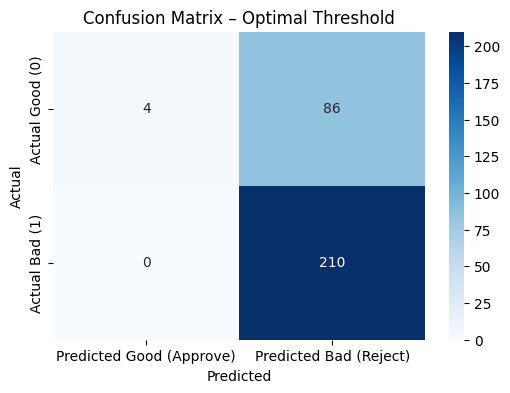

In [31]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_opt_pred)

cm_df = pd.DataFrame(
    cm,
    index=["Actual Good (0)", "Actual Bad (1)"],
    columns=["Predicted Good (Approve)", "Predicted Bad (Reject)"]
)

print(cm_df)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Optimal Threshold")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


##Best Strategy (Testing different levels of strictness to decide the best rule for approving or rejecting loan applicants)

In [32]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

thresholds = np.linspace(0.01, 0.99, 99)
rows = []

for t in thresholds:
    y_pred = (test_proba >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    good_approval_rate = tn / (tn + fp) if (tn + fp) > 0 else 0
    bad_rejection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    approval_rate = (y_pred == 0).mean()

    rows.append({
        "threshold": t,
        "good_approval_rate": good_approval_rate,
        "bad_rejection_rate": bad_rejection_rate,
        "approval_rate": approval_rate,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    })

df = pd.DataFrame(rows)


In [33]:
acceptable = df[
    (df["good_approval_rate"] >= 0.50) &
    (df["bad_rejection_rate"] >= 0.80)
]

acceptable.sort_values(
    by=["bad_rejection_rate", "good_approval_rate"],
    ascending=[False, False]
)


,threshold,good_approval_rate,bad_rejection_rate,approval_rate,tn,fp,fn,tp
57,0.58,0.511111,0.838095,0.266667,46,44,34,176
58,0.59,0.511111,0.838095,0.266667,46,44,34,176
59,0.60,0.544444,0.828571,0.283333,49,41,36,174
60,0.61,0.555556,0.809524,0.300000,50,40,40,170
61,0.62,0.588889,0.804762,0.313333,53,37,41,169


In [34]:
COST_FN = 5   # bad approved
COST_FP = 1   # good rejected

acceptable["cost"] = (
    acceptable["fn"] * COST_FN +
    acceptable["fp"] * COST_FP
)


/tmp/ipython-input-2624434911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acceptable["cost"] = (


In [35]:
best_row = acceptable.loc[acceptable["cost"].idxmin()]
best_threshold = best_row["threshold"]

best_row


,57
threshold,0.580000
good_approval_rate,0.511111
bad_rejection_rate,0.838095
approval_rate,0.266667
tn,46.000000
fp,44.000000
fn,34.000000
tp,176.000000
cost,214.000000


In [36]:
y_best_pred = (test_proba >= best_threshold).astype(int)

                 Approved (0)  Rejected (1)
Actual Good (0)            46            44
Actual Bad (1)             34           176


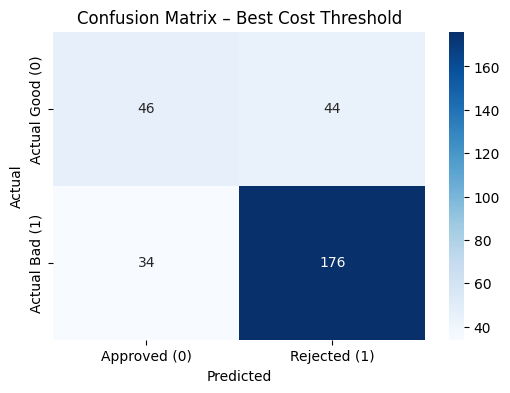

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

cm = confusion_matrix(y_test, y_best_pred)

cm_df = pd.DataFrame(
    cm,
    index=["Actual Good (0)", "Actual Bad (1)"],
    columns=["Approved (0)", "Rejected (1)"]
)

print(cm_df)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Best Cost Threshold")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [38]:
tn, fp, fn, tp = cm.ravel()

print("FINAL KPIs")
print("-" * 35)
print(f"Good approval rate: {tn / (tn + fp):.2%}")
print(f"Bad rejection rate: {tp / (tp + fn):.2%}")
print(f"Bad approved (FN): {fn}")
print(f"Good rejected (FP): {fp}")
print(f"Total cost: {fn * COST_FN + fp * COST_FP}")


FINAL KPIs
-----------------------------------
Good approval rate: 51.11%
Bad rejection rate: 83.81%
Bad approved (FN): 34
Good rejected (FP): 44
Total cost: 214


AUC : 0.767
Gini: 0.534


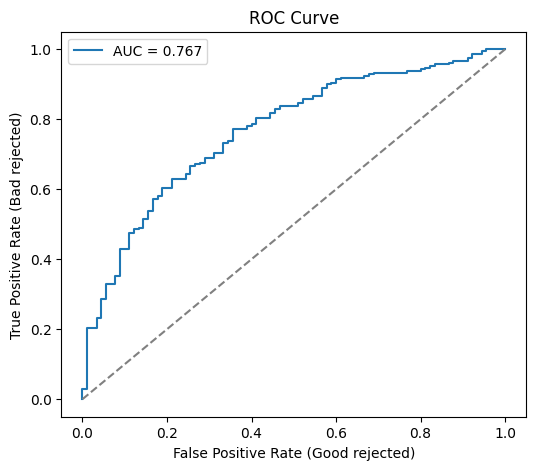

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score

auc = roc_auc_score(y_test, test_proba)
gini = 2 * auc - 1

print(f"AUC : {auc:.3f}")
print(f"Gini: {gini:.3f}")

fpr, tpr, _ = roc_curve(y_test, test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (Good rejected)")
plt.ylabel("True Positive Rate (Bad rejected)")
plt.title("ROC Curve")
plt.legend()
plt.show()


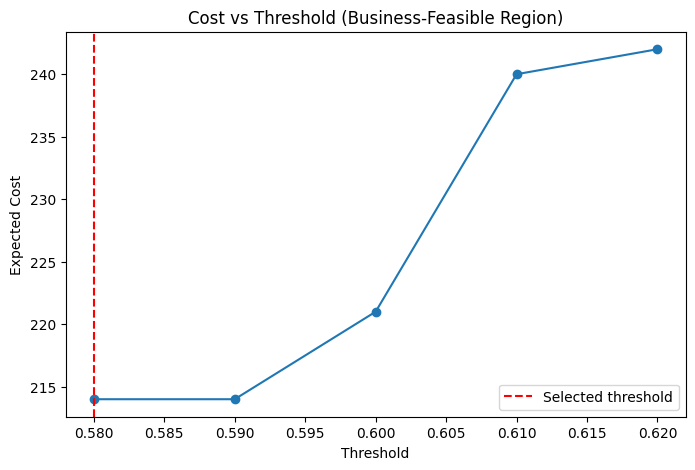

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(acceptable["threshold"], acceptable["cost"], marker="o")
plt.axvline(best_threshold, color="red", linestyle="--", label="Selected threshold")
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost vs Threshold (Business-Feasible Region)")
plt.legend()
plt.show()


**At threshold 0.58, the bank:**


*  Approves about half of good customers
*   Blocks most bad customers


*  Approves only 27% overall

*   Minimizes total financial loss


## Production Layer: Probability → Credit Score → Decision Engine

The logistic regression model outputs P(Good).
To deploy in production, probabilities are transformed into a scorecard scale.

We then define risk bands aligned with the selected strategy:
- Testing different levels of strictness to decide the best rule for approving or rejecting loan applicants.(threshold 0.58)


In [54]:
best_threshold = 0.58
buffer = 0.05

reject_threshold = best_threshold - buffer
approve_threshold = best_threshold + buffer

print("Reject if P(Good) <=", round(reject_threshold, 2))
print("Manual Review if between", round(reject_threshold, 2), "and", round(approve_threshold, 2))
print("Approve if P(Good) >=", round(approve_threshold, 2))


Reject if P(Good) <= 0.53
Manual Review if between 0.53 and 0.63
Approve if P(Good) >= 0.63


In [55]:
score_df = pd.DataFrame({
    "Actual": y_test.values,
    "Probability_Good": test_proba
})

score_df["Decision"] = np.where(
    score_df["Probability_Good"] >= approve_threshold,
    "Approve",
    np.where(
        score_df["Probability_Good"] <= reject_threshold,
        "Reject",
        "Manual Review"
    )
)


In [56]:
strategy_summary = (
    score_df
    .groupby("Decision")
    .agg(
        Volume=("Actual", "count"),
        Bad_Rate=("Actual", lambda x: 1 - x.mean()),
        Good_Rate=("Actual", "mean")
    )
)

strategy_summary


,Volume,Bad_Rate,Good_Rate
Decision,,,
Approve,278,0.276978,0.723022
Manual Review,11,0.545455,0.454545
Reject,11,0.636364,0.363636


In [57]:
# Sort by probability
score_df = score_df.sort_values("Probability_Good")

# Define review zone as ±10% around threshold in ranking space
lower_bound = score_df["Probability_Good"].quantile(0.45)
upper_bound = score_df["Probability_Good"].quantile(0.65)

score_df["Decision"] = np.where(
    score_df["Probability_Good"] >= upper_bound,
    "Approve",
    np.where(
        score_df["Probability_Good"] <= lower_bound,
        "Reject",
        "Manual Review"
    )
)


In [58]:
threshold_odds = best_threshold / (1 - best_threshold)
threshold_log_odds = np.log(threshold_odds)
score_threshold = offset + factor * threshold_log_odds

reject_score = offset + factor * np.log(reject_threshold / (1 - reject_threshold))
approve_score = offset + factor * np.log(approve_threshold / (1 - approve_threshold))

print("Reject score <=", round(reject_score, 0))
print("Manual Review between", round(reject_score, 0), "and", round(approve_score, 0))
print("Approve score >=", round(approve_score, 0))


Reject score <= 311.0
Manual Review between 311.0 and 341.0
Approve score >= 341.0


## 15. Conclusion

This notebook demonstrates a **production-ready credit scoring pipeline**.

It balances:
- Predictive power
- Business relevance
- Regulatory expectations

This approach is widely used in banks and fintech lenders.